# Extract Planck instrument parameters

In [1]:
ipac_warning = [
    "Text file in IPAC table format, read with astropy",
    "from astropy.table import QTable",
    "QTable.read('filename.tbl', format='ascii.ipac')",
    f"Instrument model exported from the Planck NPIPE instrument models",
]

In [2]:
import numpy as np
from astropy.io import fits

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
from pathlib import Path

# Check if the file does not exist before downloading
file_path = Path("PLANCK_RIMO_TF_R4.00.tar.gz")
if not file_path.exists():
    !wget https://portal.nersc.gov/cfs/cmb/planck2020/misc/PLANCK_RIMO_TF_R4.00.tar.gz
    !tar xzvf PLANCK_RIMO_TF_R4.00.tar.gz

In [5]:
RIMO = dict(
    HFI=fits.open("simulated_maps/npipe_aux/RIMO_HFI_NPIPE.fits"),
    LFI=fits.open("simulated_maps/npipe_aux/RIMO_LFI_NPIPE.fits"),
)

In [6]:
from pathlib import Path

In [7]:
from collections import OrderedDict
from astropy import units as u
from astropy.table import QTable

In [8]:
table = QTable(
    names=[
        "telescope",
        "band",
        "center_frequency",
        "fwhm",
        "nside",
        "bandpass_file",
        "beam_file",
    ],
    dtype=[str, str, float, float, int, str, str],
    units=[None, None, u.GHz, u.arcmin, None, None, None],
)

In [9]:
# Add rows for HFI and LFI
for instrument in ["LFI", "HFI"]:
    for band in RIMO[instrument][
        (
            "FREQUENCY MAP PARAMETERS"
            if instrument == "HFI"
            else "FREQUENCY_MAP_PARAMETERS"
        )
    ].data:
        center_frequency=float(band["FREQUENCY"]) * u.GHz
        if isinstance(band["FREQUENCY"], np.ndarray):
            label=band["FREQUENCY"][0]
        else:
            label=band["FREQUENCY"]
        is_polarized = center_frequency < 500 * u.GHz
        beam_filename = "Bl_"+("TEB_" if is_polarized else "") + "npipe6v20_"
        table.add_row(
            OrderedDict(
                telescope=instrument,
                band=label,
                center_frequency=center_frequency,
                fwhm=band["FWHM"] * u.arcmin,
                nside=2048 if instrument == "HFI" else 1024,
                bandpass_file="bandpass_" + label + ".tbl",
                beam_file= f'full_frequency/{beam_filename}{label:03}GHzx{label:03}GHz.fits'
            )
        )

/tmp/ipykernel_27149/4081011190.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  center_frequency=float(band["FREQUENCY"]) * u.GHz


In [10]:
table

telescope,band,center_frequency,fwhm,nside,bandpass_file,beam_file
,,GHz,arcmin,,,
str3,str3,float64,float64,int64,str16,str50
LFI,030,30.0,33.102652125,1024,bandpass_030.tbl,full_frequency/Bl_TEB_npipe6v20_030GHzx030GHz.fits
LFI,044,44.0,27.94348615,1024,bandpass_044.tbl,full_frequency/Bl_TEB_npipe6v20_044GHzx044GHz.fits
LFI,070,70.0,13.076459609999999,1024,bandpass_070.tbl,full_frequency/Bl_TEB_npipe6v20_070GHzx070GHz.fits
HFI,100,100.0,9.88,2048,bandpass_100.tbl,full_frequency/Bl_TEB_npipe6v20_100GHzx100GHz.fits
HFI,143,143.0,7.18,2048,bandpass_143.tbl,full_frequency/Bl_TEB_npipe6v20_143GHzx143GHz.fits
HFI,217,217.0,4.87,2048,bandpass_217.tbl,full_frequency/Bl_TEB_npipe6v20_217GHzx217GHz.fits
HFI,353,353.0,4.65,2048,bandpass_353.tbl,full_frequency/Bl_TEB_npipe6v20_353GHzx353GHz.fits
HFI,545,545.0,4.72,2048,bandpass_545.tbl,full_frequency/Bl_npipe6v20_545GHzx545GHz.fits


In [11]:
table.meta["comments"] = ipac_warning
table.write(f"instrument_model.tbl", format="ascii.ipac", overwrite=True)

## Create bandpass files

In [12]:
for band in ["30", "44", "70"]:
    file_path = Path(f"bp_corrected_{band}.dat")
    if not file_path.exists():
        !wget http://sdc.uio.no/vol/cosmoglobe-data/BeyondPlanck/releases/v2/BP_bandpass_profiles/bp_corrected_{band}.dat

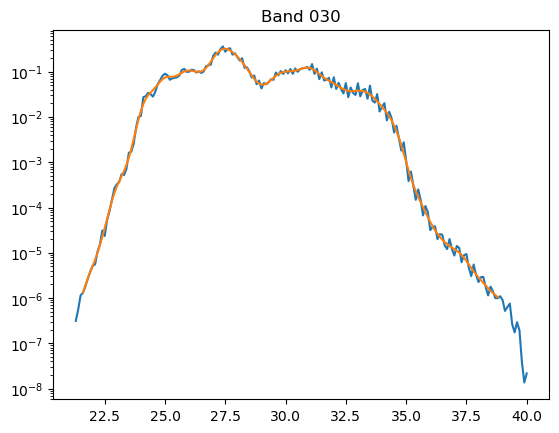

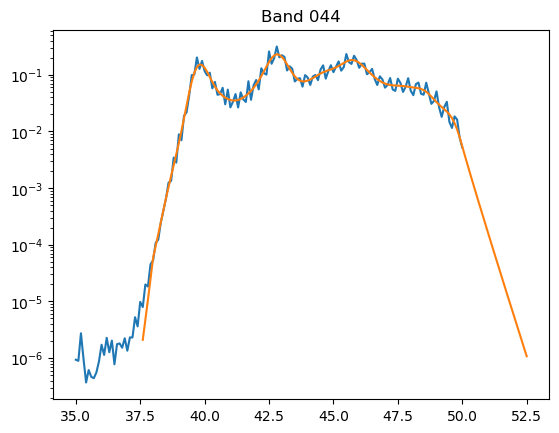

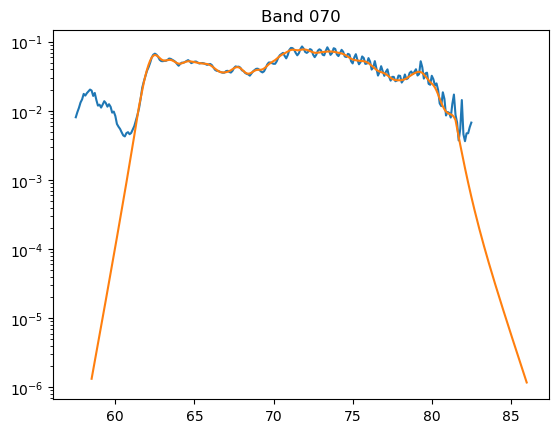

In [13]:
for band in ["030", "044", "070"]:
    corrected = np.loadtxt(f"bp_corrected_{band[1:]}.dat", unpack=True)
    plt.figure()
    plt.title(f"Band {band}")
    plt.semilogy(
        RIMO["LFI"]["BANDPASS_" + band].data["WAVENUMBER"],
        RIMO["LFI"]["BANDPASS_" + band].data["TRANSMISSION"],
        label="NPIPE",
    )
    mask = corrected[1] > 1e-6
    plt.semilogy(corrected[0][mask], corrected[1][mask], label="BeyondPlanck")

In [14]:
from astropy import constants as const

# High-Frequency Instrument (HFI) Transmission

In HFI, the transmission $\tau$ is:

$$
m_i = K_i \frac{1 + \eta_i}{2} \epsilon_i \int d\nu (A\Omega)_\nu \tau_i(\nu) dI_\nu \quad [K_{\text{CMB}}]
$$

So, it factors out the effect of $\Omega$:

$$
\Omega \propto \frac{1}{\nu^2}
$$

Instead, in LFI it is just power:

## Receiver Bandpass

The receiver bandpass, $G(\nu)$, can be determined by performing two measurements per each frequency at different input power levels:

$$
G(\nu) = \frac{\Delta V_{\text{out}}(\nu)}{\Delta P_{\text{in}}(\nu)}.
$$

Equation (2.9)

## Implementation in PySM

Given in PySM, I use the bandpass as it is. I leave the LFI as they are, and I multiply the HFI bandpasses by $\nu^2$.  
I also checked in the color correction code, they do:

```python
trans[PosFreq] = trans[PosFreq] * (wn[PosFreq] / NUC_) ** (-2d)
```

where $\text{NUC}$ is 30, 44, 70 GHz and $\text{wn}$ is $\nu$.  

So it makes sense that the code divides the LFI bandpasses by $\nu^2$ to get to the same convention of HFI.


I also need to shift by half an interval the LFI bandpasses because instead of marking the center of an interval, they mark the left edge.

In [15]:
skip = {"217": 2, "353": 3, "545": 9, "857": 12}
bandpass = {}
for ch in table:
    band = ch["band"]
    if ch["telescope"] == "HFI":
        freq = (
            RIMO["HFI"]["BANDPASS_F" + band].data["WAVENUMBER"] * (1 / u.cm) * const.c
        ).to(u.GHz)
        weight = RIMO["HFI"]["BANDPASS_F" + band].data["TRANSMISSION"]
        weight *= (freq / ch["center_frequency"]) ** 2
        weight /= weight.max()
        mask = np.logical_and(
            freq > 0.5 * ch["center_frequency"], freq < 1.5 * ch["center_frequency"]
        )
        mask = np.logical_and(mask, weight > 1e-2)
        freq = freq[mask]
        weight = weight[mask]
        if band in skip:
            freq = freq[:: skip[band]]
            weight = weight[:: skip[band]]
    else:
        corrected = np.loadtxt(f"bp_corrected_{band[1:]}.dat", unpack=True)
        df = corrected[0][1] - corrected[0][0]
        freq = corrected[0] + df / 2
        weight = corrected[1]
        weight = weight / weight.max()
        mask = weight > 1e-2
        weight = weight[mask]
        freq = freq[mask]
    bandpass[band] = QTable(
        names="bandpass_frequency bandpass_weight".split(),
        units=[u.GHz, None],
        data=[freq, weight],
    )
    bandpass[band].meta["comments"] = ipac_warning
    bandpass[band].write(f"bandpass_{band}.tbl", format="ascii.ipac", overwrite=True)

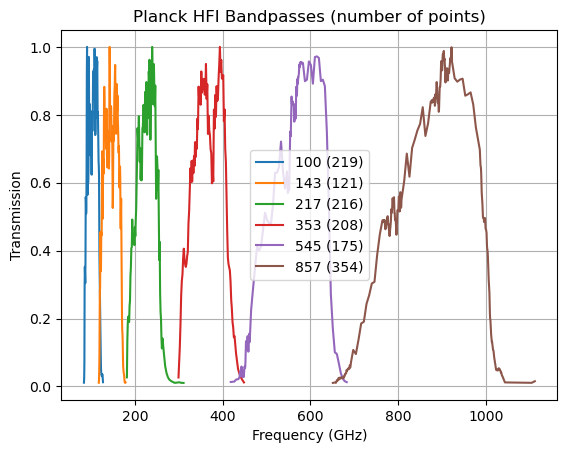

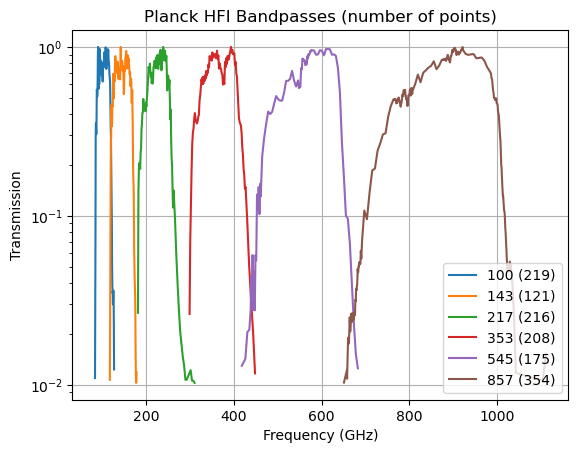

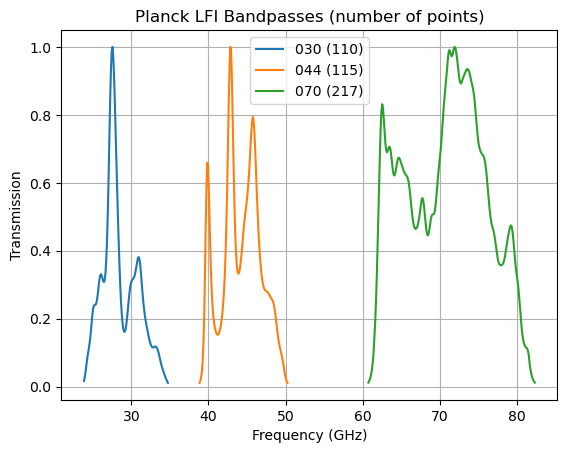

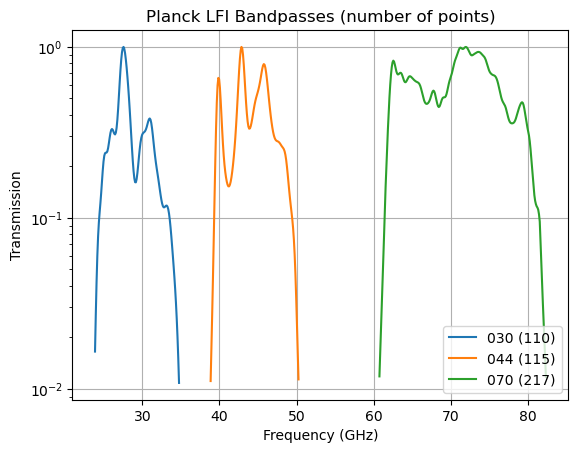

In [16]:
for instrument in ["HFI", "LFI"]:
    for plot in [plt.plot, plt.semilogy]:
        plt.figure()
        plt.title(f"Planck {instrument} Bandpasses (number of points)")
        for row in table:
            if row["telescope"] == instrument:
                plot(
                    bandpass[row["band"]]["bandpass_frequency"],
                    bandpass[row["band"]]["bandpass_weight"],
                    label=f"{row['band']} ({len(bandpass[row['band']])})",
                )
        plt.xlabel("Frequency (GHz)")
        plt.ylabel("Transmission")
        plt.grid()
        plt.legend()
    plt.show()

## Beam window function

TEB window functions for all channels except the 2 higher HFI frequencies that are unpolarized detectors.

In [17]:
beam = {}
for ch in table:
    band = ch["band"]
    print(band)
    try:
        npipe_beam = fits.open(
            f"simulated_maps/npipe_aux/beam_window_functions/full_frequency/Bl_TEB_npipe6v20_{band:03}GHzx{band:03}GHz.fits"
            )[1].data
        beam[band] = QTable(
            names=["ell", "T", "E", "B"],
            units=[None, None, None, None],
            data=[np.arange(len(npipe_beam)), npipe_beam["T"], npipe_beam["E"], npipe_beam["B"]],
        )
    except FileNotFoundError:
        npipe_beam = fits.open(
            f"simulated_maps/npipe_aux/beam_window_functions/full_frequency/Bl_npipe6v20_{band:03}GHzx{band:03}GHz.fits"
            )[1].data
        beam[band] = QTable(
            names=["ell", "T"],
            units=[None, None],
            data=[np.arange(len(npipe_beam)), npipe_beam["TEMPERATURE"]]
        )

030
044
070
100
143
217
353
545
857


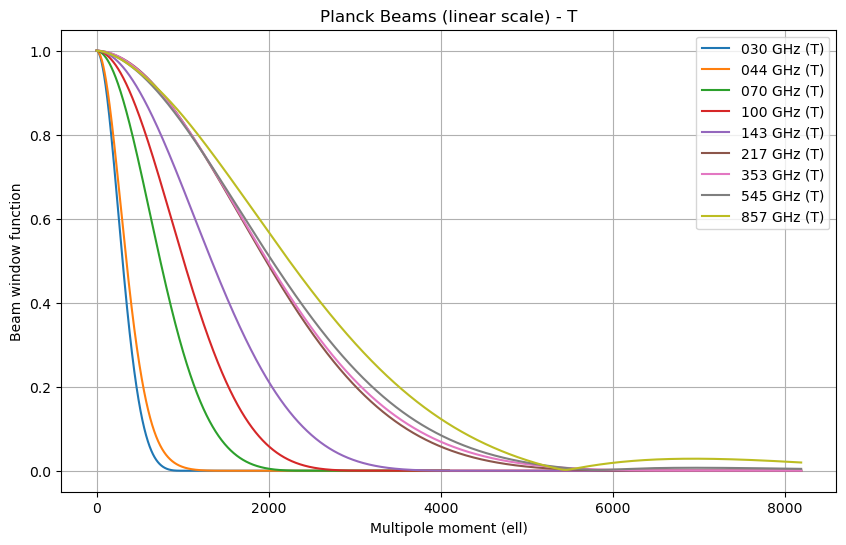

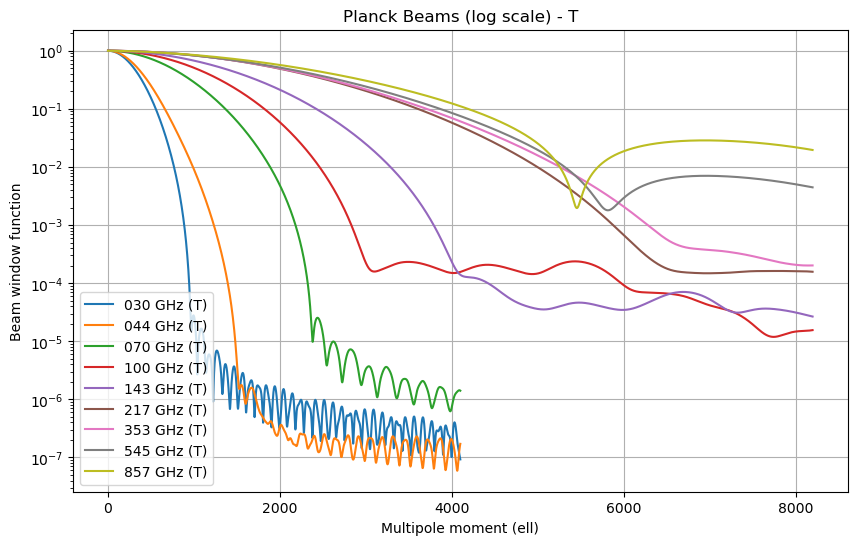

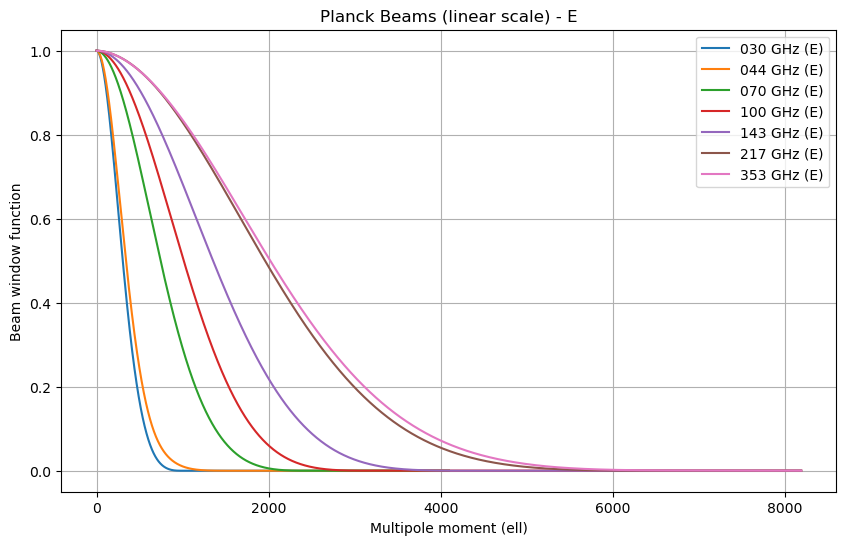

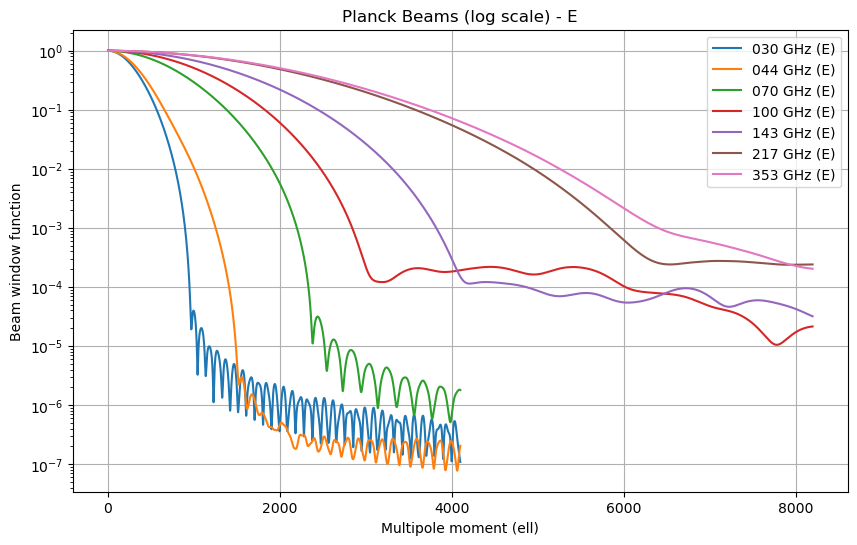

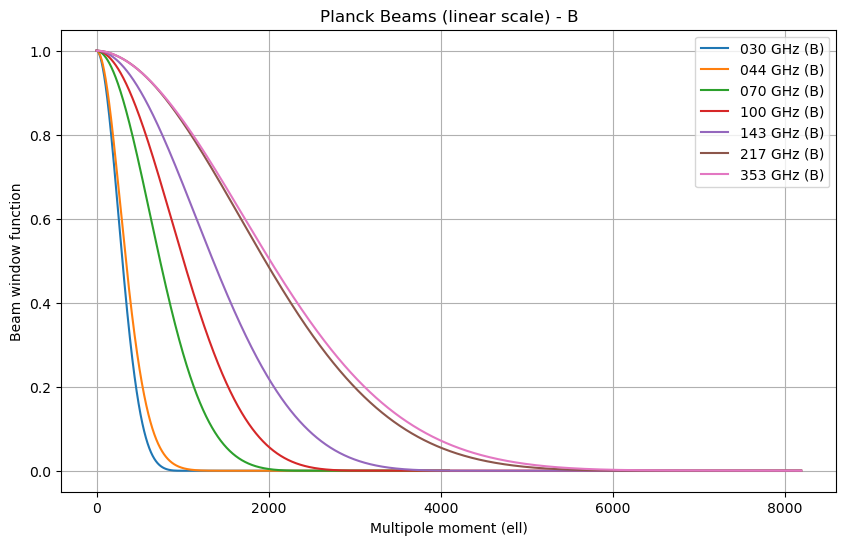

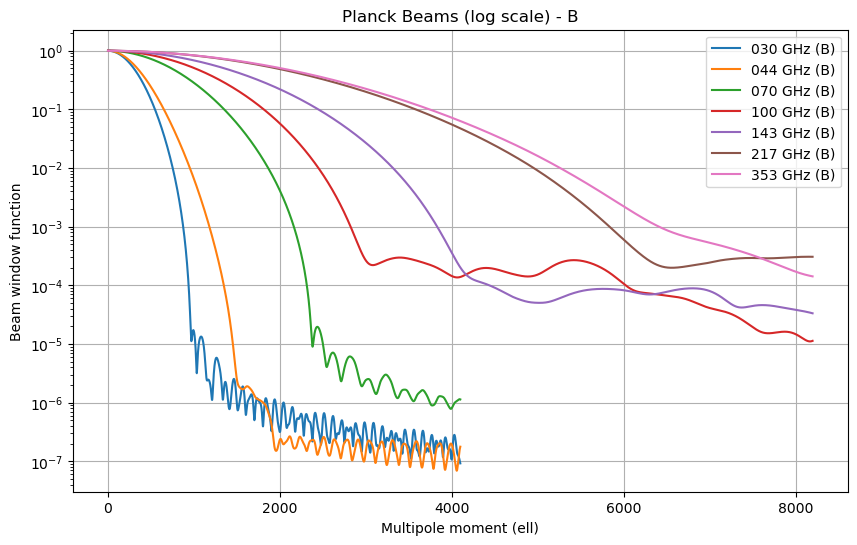

In [18]:
for component in ['T', 'E', 'B']:
    for scale in ['linear', 'log']:
        plt.figure(figsize=(10, 6))
        plt.title(f"Planck Beams ({scale} scale) - {component}")
        for band in beam:
            if component in beam[band].colnames:
                plt.plot(beam[band]['ell'], beam[band][component], label=f"{band} GHz ({component})")
        plt.xlabel('Multipole moment (ell)')
        plt.ylabel('Beam window function')
        plt.yscale(scale)
        plt.grid(True)
        plt.legend()
        plt.show()

In [19]:
for band, beam_data in beam.items():
    print(f"Band {band}:")
    for component in beam_data.colnames[1:]:  # Skip the 'ell' column
        max_value = np.max(beam_data[component])
        print(f"  {component} max: {max_value}")
        assert max_value == 1

Band 030:
  T max: 1.0
  E max: 1.0
  B max: 1.0
Band 044:
  T max: 1.0
  E max: 1.0
  B max: 1.0
Band 070:
  T max: 1.0
  E max: 1.0
  B max: 1.0
Band 100:
  T max: 1.0
  E max: 1.0
  B max: 1.0
Band 143:
  T max: 1.0
  E max: 1.0
  B max: 1.0
Band 217:
  T max: 1.0
  E max: 1.0
  B max: 1.0
Band 353:
  T max: 1.0
  E max: 1.0
  B max: 1.0
Band 545:
  T max: 1.0
Band 857:
  T max: 1.0
